# Projeto: Previsão de Vendas de Sorvete
Este notebook executa todas as etapas do projeto: carregamento dos dados, EDA, preparação, treino, avaliação e geração do modelo final.


## 1) Imports e carregamento dos dados
Carregamento do dataset original contendo temperatura e vendas de sorvete.


In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

DATA_PATH = Path("../data/raw/ice_cream_sales.csv")
df = pd.read_csv(DATA_PATH)
df.head()

,Data,Sorvetes Vendidos,Temperatura (°C)
0,1/1/2025,45,25
1,1/2/2025,50,27
2,1/3/2025,30,20
3,1/4/2025,65,30
4,1/5/2025,70,32


## 2) Visão geral dos dados
Exibição das primeiras linhas para conferência da estrutura dos dados.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Data               90 non-null     object
 1   Sorvetes Vendidos  90 non-null     int64 
 2   Temperatura (°C)   90 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.2+ KB


Inspeção de tipos, valores nulos e estatísticas básicas.

In [9]:
df.describe(include='all')

,Data,Sorvetes Vendidos,Temperatura (°C)
count,90,90.000000,90.000000
unique,90,NaN,NaN
top,1/1/2025,NaN,NaN
freq,1,NaN,NaN
mean,NaN,56.833333,27.566667
std,NaN,14.715466,4.472262
min,NaN,30.000000,19.000000
25%,NaN,45.000000,24.000000
50%,NaN,55.000000,28.000000
75%,NaN,70.000000,31.000000


Análise gráfica da relação entre temperatura e vendas.

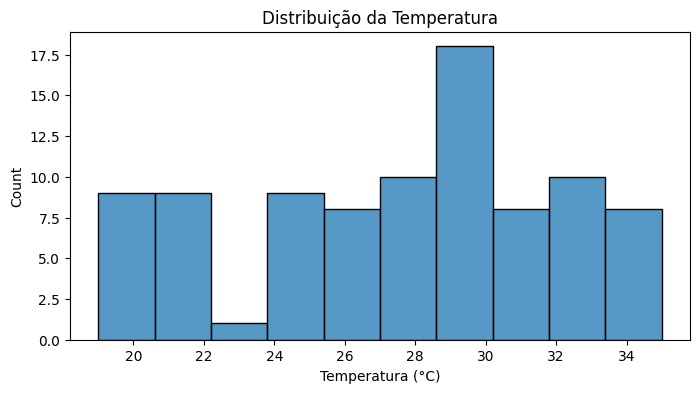

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(df['Temperatura (°C)'].dropna(), bins=10)
plt.title('Distribuição da Temperatura')
plt.xlabel('Temperatura (°C)')
plt.show()

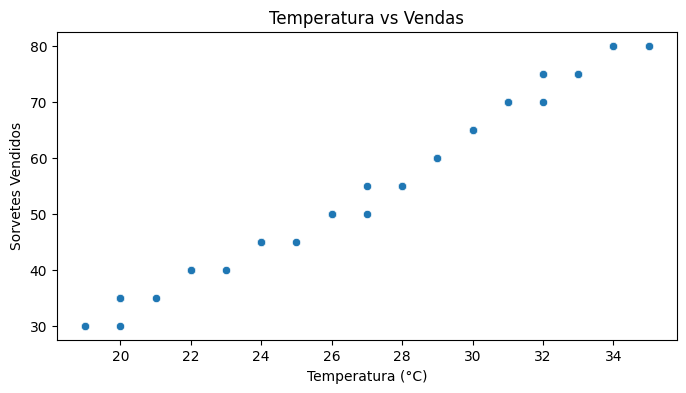

In [11]:
plt.figure(figsize=(8,4))
sns.scatterplot(x='Temperatura (°C)', y='Sorvetes Vendidos', data=df)
plt.title('Temperatura vs Vendas')
plt.show()

## 3) Preparação dos dados
Seleção de variáveis, limpeza, renomeação e estruturação final para modelagem.


In [12]:
df2 = df.rename(columns=lambda c: c.strip())
temp_col = 'Temperatura (°C)'
target_col = 'Sorvetes Vendidos'
df2 = df2[[temp_col, target_col]].dropna().rename(columns={temp_col: 'temperatura', target_col: 'vendas'})
df2['temperatura'] = pd.to_numeric(df2['temperatura'], errors='coerce')
df2['vendas'] = pd.to_numeric(df2['vendas'], errors='coerce')
df2 = df2.dropna().reset_index(drop=True)
df2.head()

,temperatura,vendas
0,25,45
1,27,50
2,20,30
3,30,65
4,32,70


## 4) Split treino/teste e normalização
Divisão dos dados em conjuntos de treinamento e teste e padronização da variável temperatura usando StandardScaler.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import joblib
ROOT = Path('/mnt/data')
proc_dir = ROOT / 'data_processed'
models_dir = ROOT / 'models'
proc_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)

X = df2[['temperatura']]
y = df2['vendas']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

train_df = pd.DataFrame(X_train_s, columns=['temperatura'])
train_df['vendas'] = y_train.values
test_df = pd.DataFrame(X_test_s, columns=['temperatura'])
test_df['vendas'] = y_test.values

train_df.to_csv(proc_dir / 'train_tratado.csv', index=False)
test_df.to_csv(proc_dir / 'test_tratado.csv', index=False)
joblib.dump(scaler, proc_dir / 'scaler.joblib')

train_df.head()

,temperatura,vendas
0,1.225016,75
1,-0.863959,45
2,0.760800,70
3,1.225016,75
4,0.064475,55


## 5) Treino de modelos e seleção
Treinamento de diferentes modelos de regressão para comparação de desempenho.


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib

X_tr = X_train_s
X_val = X_test_s
y_tr = y_train.values
y_val = y_test.values

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42)
}

try:
    from xgboost import XGBRegressor
    models['XGBoost'] = XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
except Exception:
    pass

best_model = None
best_rmse = np.inf
results = {}

for name, m in models.items():
    m.fit(X_tr, y_tr)
    preds = m.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    rmse = mean_squared_error(y_val, preds) ** 0.5
    r2 = r2_score(y_val, preds)
    results[name] = {'mae': mae, 'rmse': rmse, 'r2': r2}
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = m

joblib.dump(best_model, models_dir / 'melhor_modelo.pkl')
results

{'LinearRegression': {'mae': 1.8929442412149413,
  'rmse': 2.2080701585768865,
  'r2': 0.9810190937895575},
 'RandomForest': {'mae': 0.4271896197937879,
  'rmse': 0.9430917084711902,
  'r2': 0.9965374260321992},
 'XGBoost': {'mae': 0.3242432177066803,
  'rmse': 1.19474150539331,
  'r2': 0.9944429993629456}}

## 6) Avaliação detalhada
Avaliação dos modelos usando métricas de validação e escolha do mais preciso.


MAE: 0.4272
RMSE: 0.9431
R2: 0.9965


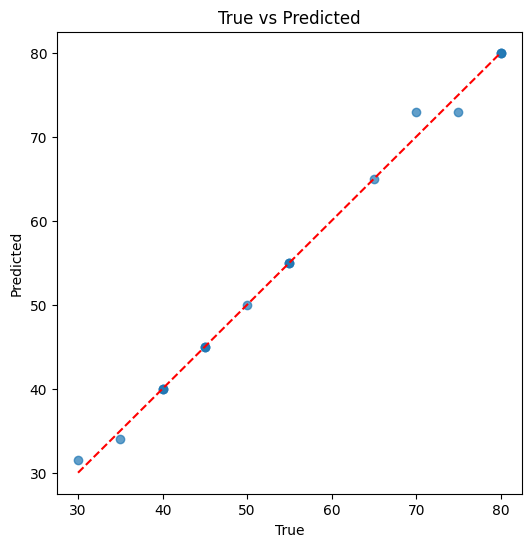

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

model = joblib.load(models_dir / 'melhor_modelo.pkl')
preds = model.predict(X_test_s)
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds) ** 0.5
r2 = r2_score(y_test, preds)
print('MAE:', round(mae,4))
print('RMSE:', round(rmse,4))
print('R2:', round(r2,4))

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs Predicted')
plt.show()

## 7) Exemplos de predição
Demonstração de uma previsão única usando o modelo treinado.


In [ ]:
example = {'temperatura': 30.0}
scaler = joblib.load(proc_dir / 'scaler.joblib')
model = joblib.load(models_dir / 'melhor_modelo.pkl')
import pandas as pd
X_ex = pd.DataFrame([[example['temperatura']]], columns=['temperatura'])
X_ex_s = scaler.transform(X_ex)
pred = model.predict(X_ex_s)
print('Input temperatura:', example['temperatura'])
print('Previsão de vendas:', float(pred[0]))

Input temperatura: 30.0
Previsão de vendas: 65.0
